<center>
<p><img src="files/figs/nbalogo.jpg"></p>
<h1 style="font-size:50px">Analyzing and Predicting NBA Awards</h1>
<h4 style="font-size:20px">Mary Hood, Manpreet Sidhu, Alex Rothman</h4>
<hr>
</center>



<center>
<h1 style="font-size:30px">Introduction</h1>
</center>
<p>
    The National Basketball Association (NBA) is the leading professional basketball league in North America. The league consists of 30 teams and is divided into two conferences, the Eastern and the Western conferences. Each team plays 82 games during the regular season. After the regular season is over, teams compete in playoffs in order to qualify for the NBA Finals. The NBA Finals are when the winning teams for both conferences faceoff in a best-of-seven game series for the title of NBA champions and for the Larry O'Brien Championship Trophy. After the series is over, the NBA hosts an awards ceromony celebrating the accomplishments of its players. Our project will be analyzing and predicting the results of those NBA Awards.
</p>
<p>
    The three awards we will be investigating are Most Valuable Player (MVP), Rookie of the Year (ROY), and Defensive Player of the Year (DPOY). It is important to note that these awards are given out based upon regular season statistics only. This means that a player's playoff and potential NBA Finals performance should have no impact on their odds of winning one of these awards. The MVP award is given to the best performing player of the regular season. The ROY award is given to the top rookie of the regular season. The DPOY award is given to the best performing defensive player of the regular season. Before we attempted to predict the winners of awards this year, we decided to look into the statistics of the 2018-2019 season.
</p>

<center>
<h1 style="font-size:28px">Getting Started With The Data</h1>
</center>

In [2]:
# Imports any necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn import utils
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
pd.set_option('display.max_columns', 500)

<center>
<h1 style="font-size:28px">2018-2019 NBA Season Stats</h1>
</center>
<p>
    The following code snippet populates a Pandas Dataframe with statistics on all NBA players during the 2018-2019 season. We used Basketball-Reference.com as the source of the 2018-2019 season statistics. The nba_stats dataframe will hold the season statistics from their dataset of "per game" player statistics found <a href="https://www.basketball-reference.com/leagues/NBA_2019_per_game.html">here</a> and of "advanced" player statistics found <a href="https://www.basketball-reference.com/leagues/NBA_2019_advanced.html">here</a>. The two datasets were merged and then the resulting dataframe was sorted by the average points scored per game for every player entry. 
</p>

In [3]:
# Reads the per game player statistics dataset in as nba_stats_regular
nba_stats_regular = pd.read_csv("18_19_stats.csv")
nba_stats_regular = nba_stats_regular.drop(columns = ["Rk"])

# Reads the advanced player statistics dataset in as nba_stats_advanced
nba_stats_advanced = pd.read_csv("18_19_stats_advanced.csv")
nba_stats_advanced = nba_stats_advanced.drop(columns = ["Rk"])

# General helper function to clean up the formatting of the player name column
# This will be used throughout our code
def clean_name_column(dataframe):
    for i, row in dataframe.iterrows():
        player = row.Player
        name_split = player.split('\\')
        player_name = name_split[0]
        dataframe.at[i, 'Player'] = player_name

# Clean the datasets
clean_name_column(nba_stats_regular)
clean_name_column(nba_stats_advanced)

# Merge the per game and advanced player statistics together. Drops any duplicate columns.
nba_stats = nba_stats_regular.merge(right = nba_stats_advanced, how = 'outer', suffixes = ('', '_repeat'), 
                                    left_index = True, right_index = True)

# Drop any repeated columns (they end in _repeat)
nba_stats = nba_stats[nba_stats.columns.drop(list(nba_stats.filter(regex='_repeat')))]

# Sort the dataframe by points
nba_stats = nba_stats.sort_values(by="PTS", ascending = False)

nba_stats = nba_stats.reset_index()
nba_stats = nba_stats.drop(columns = ["index"])

nba_stats

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,James Harden,PG,29,HOU,78,78,36.8,10.8,24.5,0.442,4.8,13.2,0.368,6.0,11.3,0.528,0.541,9.7,11.0,0.879,0.8,5.8,6.6,7.5,2.0,0.7,5.0,3.1,36.1,30.6,0.616,0.539,0.449,2.5,17.8,10.0,39.5,2.7,1.7,14.5,40.5,11.4,3.8,15.2,0.254,10.5,1.1,11.7,9.9
1,Paul George,SF,28,OKC,77,77,36.9,9.2,21.0,0.438,3.8,9.8,0.386,5.4,11.1,0.484,0.529,5.9,7.0,0.839,1.4,6.8,8.2,4.1,2.2,0.4,2.7,2.8,28.0,23.3,0.583,0.469,0.335,3.7,19.6,11.4,17.7,2.8,1.0,10.0,29.5,7.0,4.9,11.9,0.201,4.7,0.7,5.5,5.3
2,Giannis Antetokounmpo,PF,24,MIL,72,72,32.8,10.0,17.3,0.578,0.7,2.8,0.256,9.3,14.5,0.641,0.599,6.9,9.5,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7,30.9,0.644,0.163,0.550,7.3,30.0,19.3,30.3,1.8,3.9,14.8,32.3,8.9,5.5,14.4,0.292,5.7,5.0,10.8,7.6
3,Joel Embiid,C,24,PHI,64,64,33.7,9.1,18.7,0.484,1.2,4.1,0.300,7.8,14.6,0.535,0.517,8.2,10.1,0.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,3.3,27.5,26.1,0.593,0.219,0.541,8.1,34.0,21.4,18.4,1.0,4.4,13.2,33.3,4.9,3.8,8.7,0.194,2.0,2.1,4.1,3.3
4,LeBron James,SF,34,LAL,55,55,35.2,10.1,19.9,0.510,2.0,5.9,0.339,8.1,14.0,0.582,0.560,5.1,7.6,0.665,1.0,7.4,8.5,8.3,1.3,0.6,3.6,1.7,27.4,25.6,0.588,0.299,0.382,3.1,21.3,12.4,39.4,1.7,1.4,13.3,31.6,4.7,2.6,7.2,0.179,6.2,1.9,8.1,4.9
5,Stephen Curry,PG,30,GSW,69,69,33.8,9.2,19.4,0.472,5.1,11.7,0.437,4.0,7.7,0.525,0.604,3.8,4.2,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3,24.4,0.641,0.604,0.214,2.2,14.2,8.4,24.2,1.9,0.9,11.6,30.4,7.2,2.5,9.7,0.199,7.7,-1.4,6.3,4.9
6,Devin Booker,SG,22,PHO,64,64,35.0,9.2,19.6,0.467,2.1,6.5,0.326,7.0,13.1,0.536,0.521,6.1,7.1,0.866,0.6,3.5,4.1,6.8,0.9,0.2,4.1,3.1,26.6,20.2,0.584,0.330,0.362,1.9,11.3,6.5,34.1,1.2,0.5,15.4,32.9,3.3,0.3,3.5,0.076,3.8,-3.0,0.8,1.6
7,Kawhi Leonard,SF,27,TOR,60,60,34.0,9.3,18.8,0.496,1.9,5.0,0.371,7.5,13.8,0.542,0.546,6.1,7.1,0.854,1.3,6.0,7.3,3.3,1.8,0.4,2.0,1.5,26.6,25.8,0.606,0.267,0.377,4.2,18.6,11.6,16.4,2.5,1.0,8.4,30.3,6.1,3.4,9.5,0.224,4.3,0.7,5.0,3.6
8,Kevin Durant,SF,30,GSW,78,78,34.6,9.2,17.7,0.521,1.8,5.0,0.353,7.5,12.8,0.587,0.571,5.7,6.5,0.885,0.4,5.9,6.4,5.9,0.7,1.1,2.9,2.0,26.0,24.2,0.631,0.281,0.366,1.4,17.5,9.8,26.2,1.0,2.6,12.3,29.0,8.6,2.9,11.5,0.204,4.2,0.1,4.3,4.3
9,Anthony Davis,C,25,NOP,56,56,33.0,9.5,18.3,0.517,0.9,2.6,0.331,8.6,15.7,0.547,0.540,6.1,7.7,0.794,3.1,8.9,12.0,3.9,1.6,2.4,2.0,2.4,25.9,30.3,0.597,0.141,0.422,9.9,27.5,18.8,19.0,2.2,6.0,8.4,29.5,6.4,3.1,9.5,0.247,4.7,3.9,8.5,4.9


There is a ton of data on every NBA player from the 2018-2019 season stored within the dataframe. Not all of the statistics we have stored will be used in our analysis or predictions. However, we have decided to keep all of the information for any viewers interested in seeing other relevant player statistics. Listed below are what each of the abbreviated column names stand for. The definitions of any columns used during our analysis/predictions will be restated when utilized; however, definitions for all of these terms can be found in the glossaries of each dataset linked above.

<ul style="list-style-type:none;">   
<li>Pos -- Position</li>
<li>Age -- Age of Player at the start of February 1st of that season.</li>
<li>Tm -- Team</li>
<li>G -- Games</li>
<li>GS -- Games Started</li>
<li>MP -- Minutes Played Per Game</li>
<li>FG -- Field Goals Per Game</li>
<li>FGA -- Field Goal Attempts Per Game</li>
<li>FG% -- Field Goal Percentage</li>
<li>3P -- 3-Point Field Goals Per Game</li>
<li>3PA -- 3-Point Field Goal Attempts Per Game</li>
<li>3P% -- FG% on 3-Pt FGAs</li>
<li>2P -- 2-Point Field Goals Per Game</li>
<li>2PA -- 2-Point Field Goal Attempts Per Game</li>
<li>2P% -- FG% on 2-Pt FGAs</li>
<li>eFG% -- Effective Field Goal Percentage</li>
<li>FT -- Free Throws Per Game</li>
<li>FTA -- Free Throw Attempts Per Game</li>
<li>FT% -- Free Throw Percentage</li>
<li>ORB -- Offensive Rebounds Per Game</li>
<li>DRB -- Defensive Rebounds Per Game</li>
<li>TRB -- Total Rebounds Per Game</li>
<li>AST -- Assists Per Game</li>
<li>STL -- Steals Per Game</li>
<li>BLK -- Blocks Per Game</li>
<li>TOV -- Turnovers Per Game</li>
<li>PF -- Personal Fouls Per Game</li>
<li>PTS -- Points Per Game</li>   
<li>PER -- Player Efficiency Rating</li>
<li>TS% -- True Shooting Percentage</li>
<li>3PAr -- 3-Point Attempt Rate</li>
<li>FTr -- Free Throw Attempt Rate</li>
<li>ORB% -- Offensive Rebound Percentage</li>
<li>DRB% -- Defensive Rebound Percentage</li>
<li>TRB% -- Total Rebound Percentage</li>
<li>AST% -- Assist Percentage</li>
<li>STL% -- Steal Percentage</li>
<li>BLK% -- Block Percentage</li>
<li>TOV% -- Turnover Percentage</li>
<li>USG% -- Usage Percentage</li>
<li>OWS -- Offensive Win Shares</li>
<li>DWS -- Defensive Win Shares</li>
<li>WS -- Win Shares</li>
<li>WS/48 -- Win Shares Per 48 Minutes</li>
<li>OBPM -- Offensive Box Plus/Minus</li>
<li>DBPM -- Defensive Box Plus/Minus</li>
<li>BPM -- Box Plus/Minus</li>
<li>VORP -- Value over Replacement Player</li>
    
</ul>



<center>
<h1 style="font-size:24px">Points Scored v. Minutes Played For All NBA Players</h1>
</center>
<p>
    Maybe add something here?
</p>

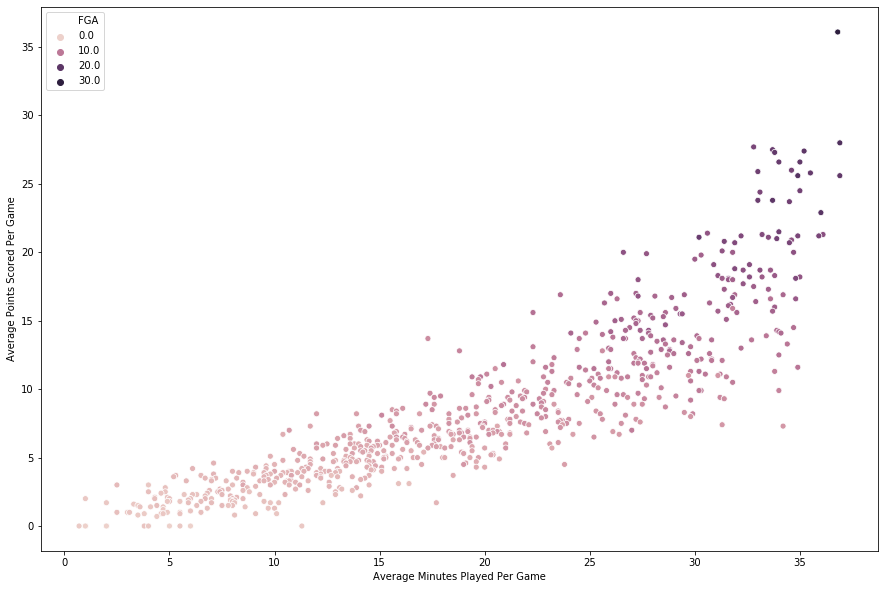

In [4]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average points scored vs average minutes played for every player
ax = sns.scatterplot(x = 'MP', y = 'PTS', hue = 'FGA', data = nba_stats)

# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Points Scored Per Game')

plt.show()

The above graph plots the average minutes played and average points scored for every player during the 2018-2019 season. Additionally, the hue of each circle represents how many field goals (2 or 3 point shots) per game that the player has attempted on average. The darker color the circle, then the more shots that player takes during games. This graph demonstrates that the more minutes a NBA player is alloted in a game, the more points they will most likely score. However, the point behind this graph was primarily to show that there are clearly groups of players who tend to be playing and scoring more than other players. The players in the upper/middle right of the graph are the ones we will be looking at to win awards such as MVP and ROY.

<center>
<h1 style="font-size:24px">Points Scored v. Minutes Played for Top 15 Scorers</h1>
</center>

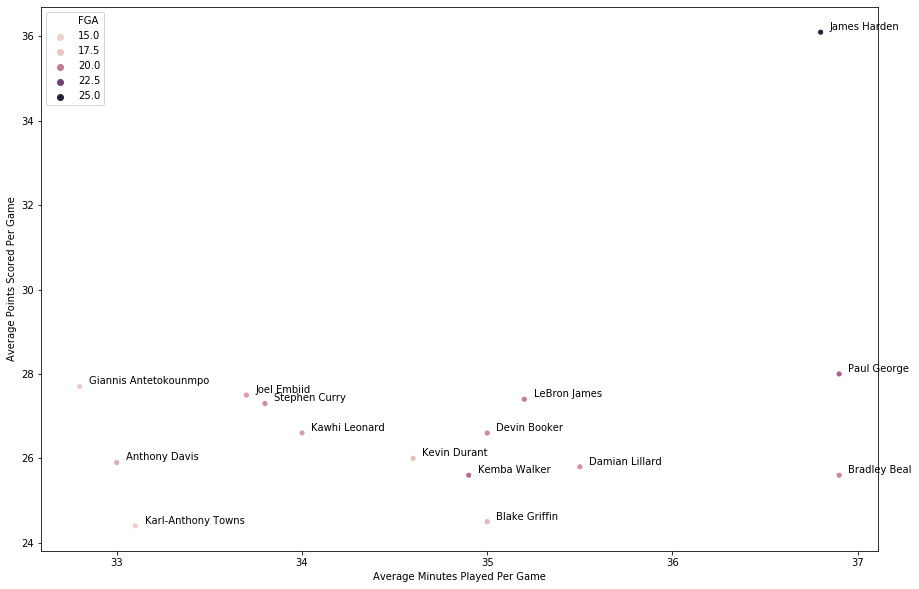

In [5]:
plt.figure(figsize=(15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Create a scatterplot of the average points scored vs average minutes played for top 15 players
ax = sns.scatterplot(x = 'MP', y = 'PTS', hue = 'FGA', data = top_15)

# Add players' names to their points on the plot
for line in range(0,top_15.shape[0]):
    plt.text(top_15.MP[line] + 0.05, top_15.PTS[line] + 0.05,
            top_15.Player[line], horizontalalignment = 'left',
            size = '10', color = 'black')

# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Points Scored Per Game')
    
plt.show()

Just like the prior graph, this graph plots the average minutes played and average points scored by players during the 2018-2019 season. However, this graph focuses on only the top 15 players with the highest average points scored per game instead of every player. Additionally, the hue of each circle still represents how many field goals (2 or 3 point shots) per game on average that the player has attempted. It is important to note that FGA amount for each hue is different from the prior graph. Logically, it makes sense to assume that the MVP has to be one of these top 15 scorers. All the players with points on the graph are very well known and have been in the NBA for multiple years. It is also important to note that points and minutes played are not the only factor in selecting an MVP. Despite James Harden having such a large number of points last year per game, the MVP award was given to Giannis Antetokounmpo who had less points and less minutes played on average. 


LOOK TO SEE IF ANY OF THE PAST MVPS WERE NOT IN THE TOP 15 SCORERS SO WE CAN SAY THAT

<center>
<h1 style="font-size:24px">Field Goals Attempted v. Field Goal Percentage For All NBA Players</h1>
</center>

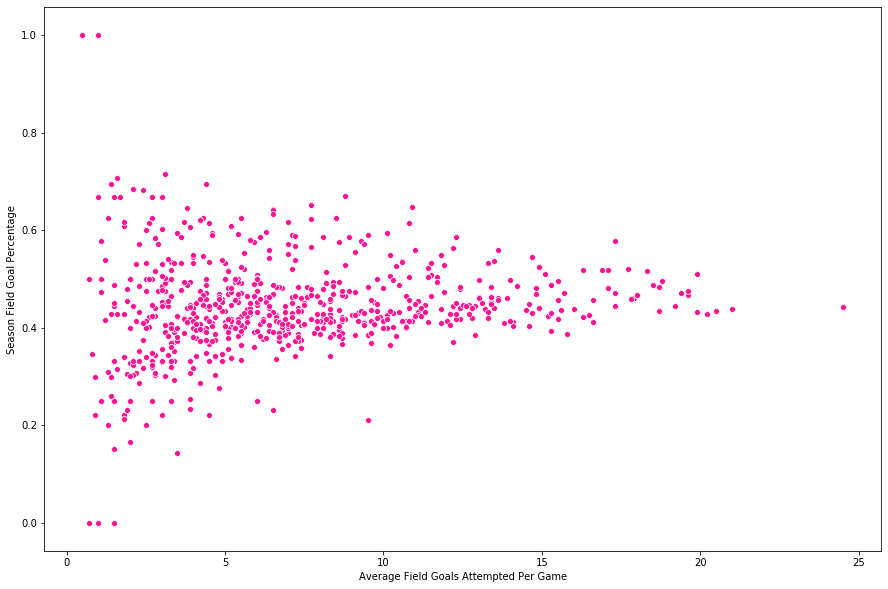

In [112]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average field goals attempted vs field goal percentage for all players
ax = sns.scatterplot(x = 'FGA', y = 'FG%', data = nba_stats, color='deeppink')

# Set up axis
ax.set_xlabel('Average Field Goals Attempted Per Game')
ax.set_ylabel('Season Field Goal Percentage')

plt.show()

- Explanation of graph. What we are gaining from it / what it is showing

The above graph plots the average field goals attempted vs the field goal percentage for all players during the 2018-2019 season. This graph demonstrates 

<center>
<h1 style="font-size:24px">Field Goals Attempted v. Field Goal Percentage For Top 15 Scorers</h1>
</center>

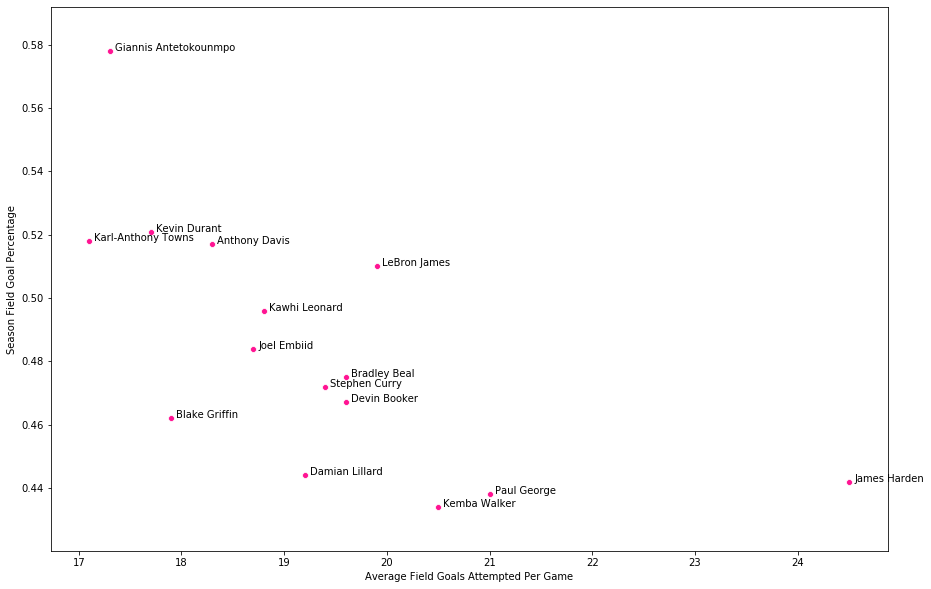

In [111]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average field goals attempted vs field goal percentage for top 15 players
ax = sns.scatterplot(x = 'FGA', y = 'FG%', data = top_15, color='deeppink')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['FGA'][line] + 0.05, top_15['FG%'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axis
ax.set_xlabel('Average Field Goals Attempted Per Game')
ax.set_ylabel('Season Field Goal Percentage')
    
plt.show()

- Explanation of graph. What we are gaining from it / what it is showing
- Difference between these players and entire NBA

Just like the prior graph, this graph plots the number of field goals attempted and the percent of field goals that went in by players during the 2018-2019 season. This graph focuses on only the top 15 players with the highest average points scored per game instead of every player. 


 <center>
<h1 style="font-size:24px">Total Rebounds v. Minutes Played For All NBA Players</h1>
</center>

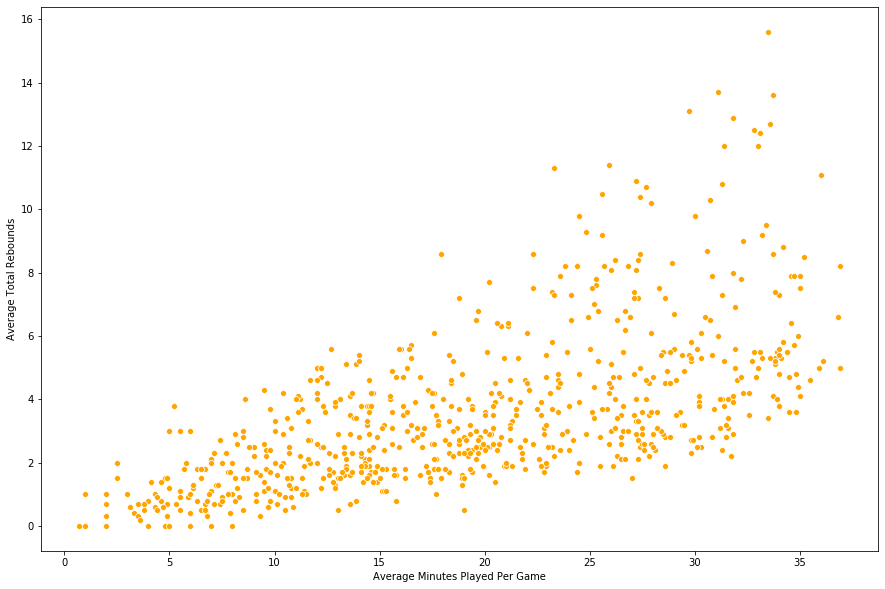

In [94]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average total rebounds vs average minutes played for top 15 players
ax = sns.scatterplot(x = 'MP', y = 'TRB', data = nba_stats, color='orange')

# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Total Rebounds')

plt.show()

The above graph plots the average total rebounds and the average minutes played for all players during the 2018-2019 season. This graph demonstrates that overall the more minutes a player plays, the more rebounds he completes. 

<center>
<h1 style="font-size:24px">Total Rebounds v. Minutes Played For Top 15 Scorers</h1>
</center>

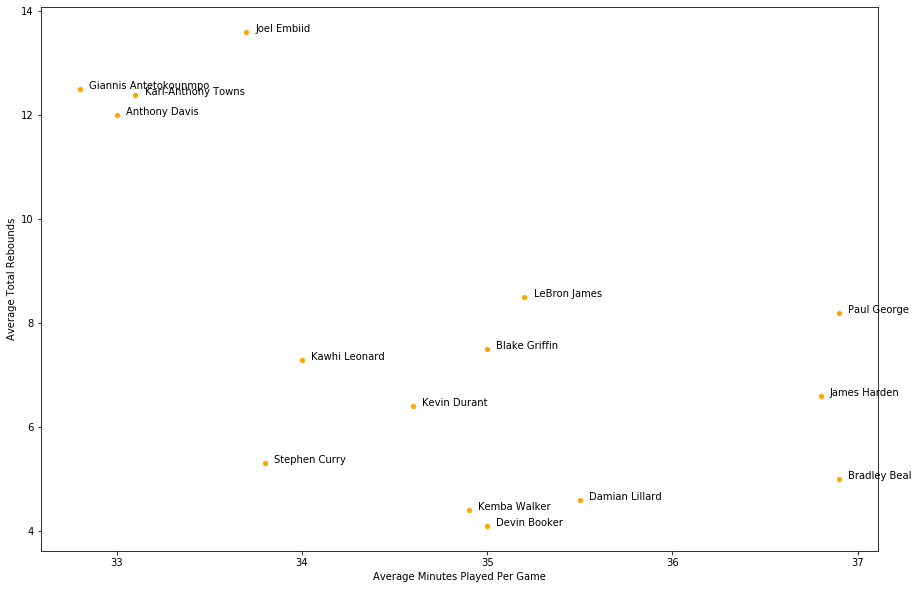

In [117]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average total rebounds vs average minutes played for top 15 players
ax = sns.scatterplot(x = 'MP', y = 'TRB', data = top_15, color='orange')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['MP'][line] + 0.05, top_15['TRB'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Total Rebounds')

plt.show()

<center>
<h1 style="font-size:24px">Total Assists v. Minutes Played For All NBA Players</h1>
</center>

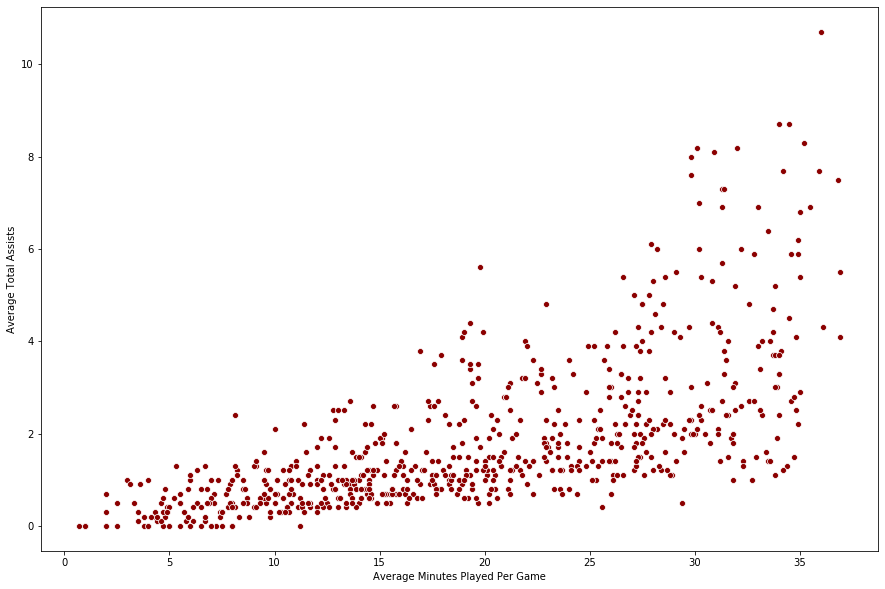

In [101]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average total assists vs average minutes played for all players
ax = sns.scatterplot(x = 'MP', y = 'AST', data = nba_stats, color='darkred')

# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Total Assists')

plt.show()

<center>
<h1 style="font-size:24px">Total Assists v. Minutes Played For Top 15 Scorers</h1>
</center>

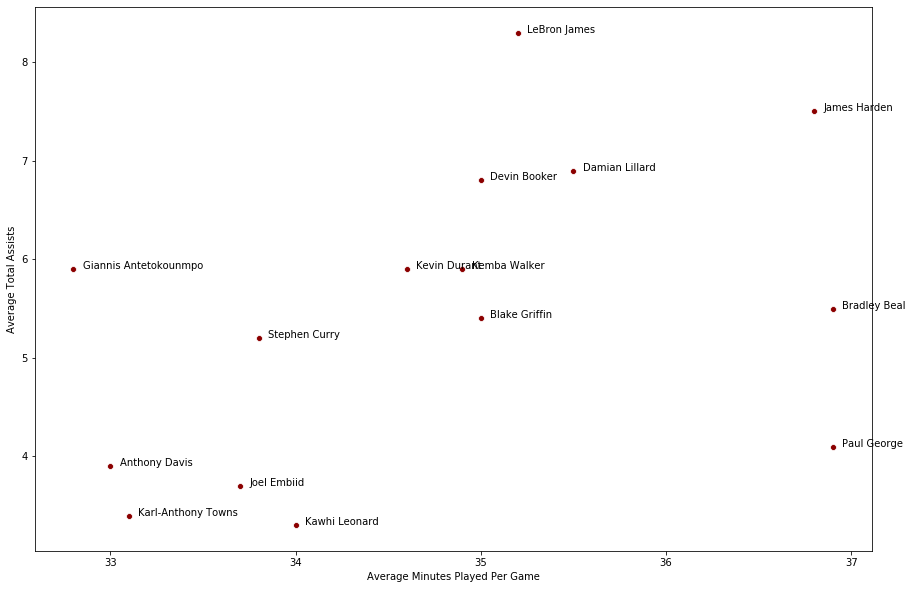

In [102]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average total assits vs average minutes played for top 15 players
ax = sns.scatterplot(x = 'MP', y = 'AST', data = top_15, color='darkred')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['MP'][line] + 0.05, top_15['AST'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Total Assists')

plt.show()

<center>
<h1 style="font-size:24px">Total Steals v. Minutes Played For All NBA Players</h1>
</center>

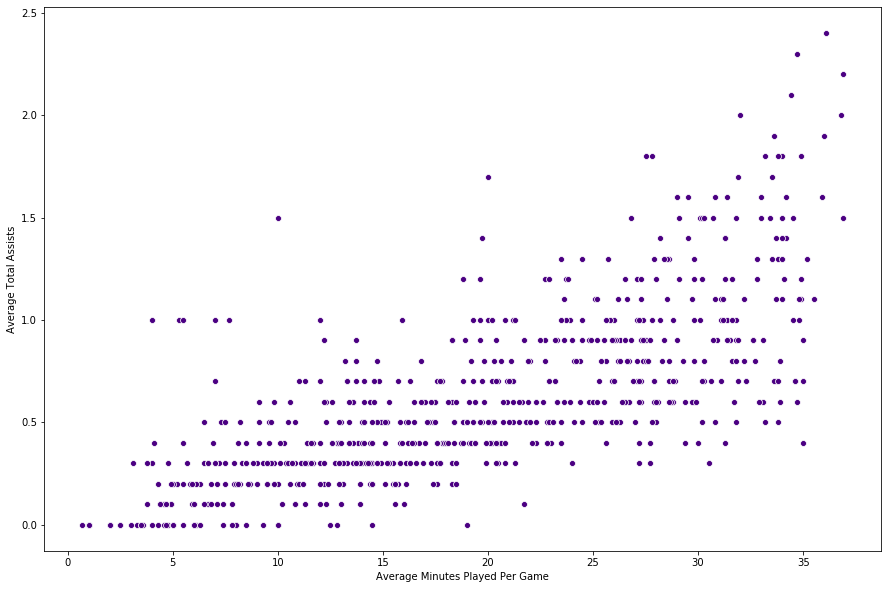

In [103]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average total steals vs average minutes played for all players
ax = sns.scatterplot(x = 'MP', y = 'STL', data = nba_stats, color='indigo')

# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Total Assists')

plt.show()

<center>
<h1 style="font-size:24px">Total Steals v. Minutes Played For Top 15 Scorers</h1>
</center>

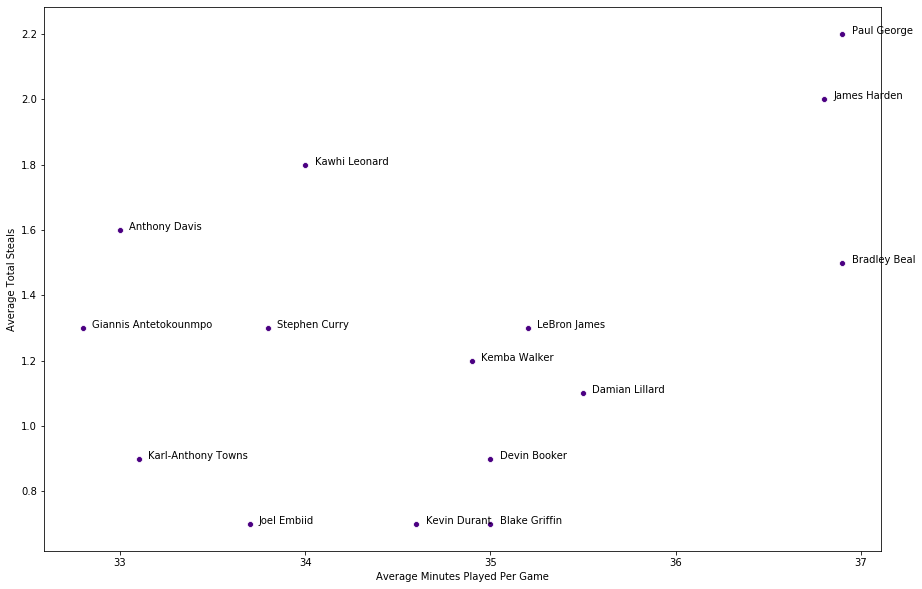

In [104]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average total steals vs average minutes played for top 15 players
ax = sns.scatterplot(x = 'MP', y = 'STL', data = top_15, color='indigo')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['MP'][line] + 0.05, top_15['STL'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')
    
# Set up axis
ax.set_xlabel('Average Minutes Played Per Game')
ax.set_ylabel('Average Total Steals')

plt.show()

~ Description of graph ~

<center>
<h1 style="font-size:24px"> Free Throw Percentage v. Free Throw Attempts For All NBA Players</h1>
</center>

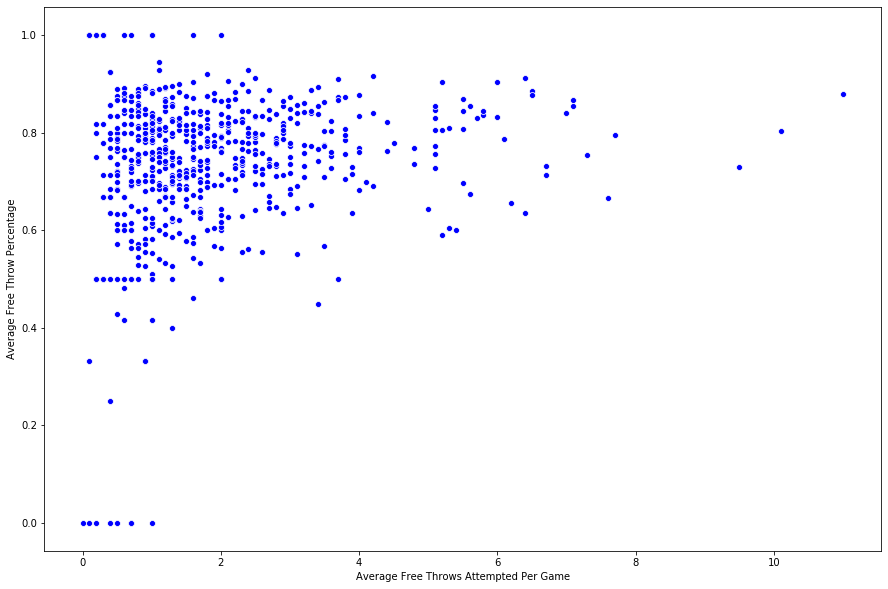

In [121]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average free throw percentage vs average free throw attempts for all players
ax = sns.scatterplot(x = 'FTA', y = 'FT%', data = nba_stats, color='blue')

# Set up axis
ax.set_xlabel('Average Free Throws Attempted Per Game')
ax.set_ylabel('Average Free Throw Percentage')

plt.show()

~ Description of graph ~

<center>
<h1 style="font-size:24px"> Free Throw Percentage v. Free Throw Attempts For Top 15 Scorers</h1>
</center>

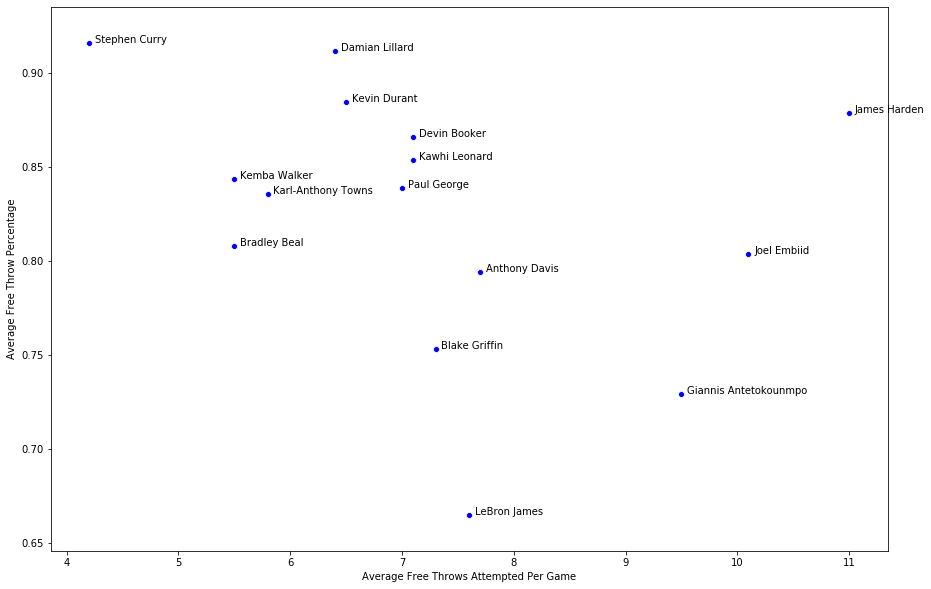

In [122]:
plt.figure(figsize=(15, 10))
# Create a scatterplot of the average free throw percentage vs average free throw attempts for top 15 players
ax = sns.scatterplot(x = 'FTA', y = 'FT%', data = top_15, color='blue')

# Lable points with player's name associated with them
for line in range(0,top_15.shape[0]):
    plt.text(top_15['FTA'][line] + 0.05, top_15['FT%'][line],
            top_15['Player'][line], horizontalalignment = 'left',
            size = '10', color = 'black')

# Set up axis
ax.set_xlabel('Average Free Throws Attempted Per Game')
ax.set_ylabel('Average Free Throw Percentage')

plt.show()

~ Description of graph ~

One can clearly see the top players are outliers in the statistics above. For the advanced statistics, 
we will only focus on the top 15 players.

<center>
<h1 style="font-size:24px"> Player Efficiency Rating v. Player For Top 15 Scorers</h1>
</center>

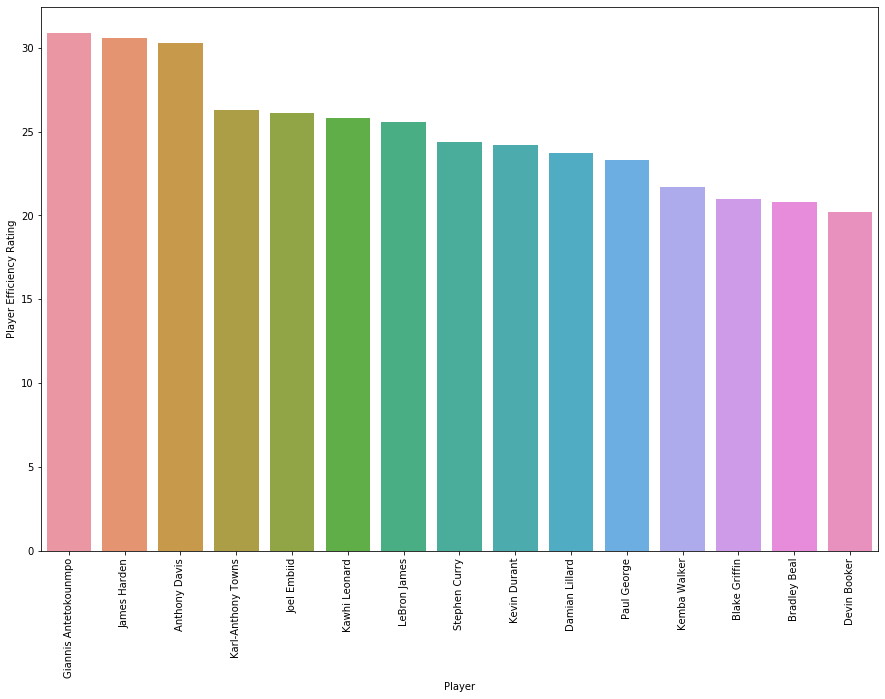

In [80]:
plt.figure(figsize=(15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by player efficiency rating in decending order
top_15 = top_15.sort_values(by=['PER'], ascending=False)
# Create a barplot of the player efficiency rating for the top 15 players
ax = sns.barplot(x = 'Player', y = 'PER', data = top_15)

# Set up axis
ax.set_xlabel('Player')
ax.set_ylabel('Player Efficiency Rating')

# Make x axis lables vertical
plt.xticks(rotation='vertical')

plt.show()

~ Description of graph ~

<center>
<h1 style="font-size:24px"> Box Plus/Minus v. Player For Top 15 Scorers</h1>
</center>

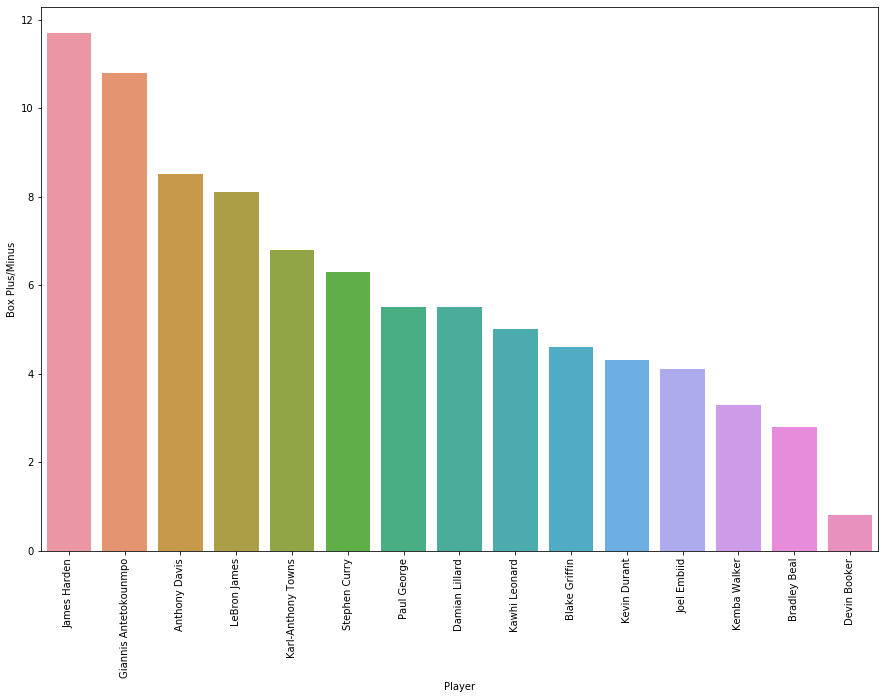

In [79]:
plt.figure(figsize=(15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by box plus/minus in decending order
top_15 = top_15.sort_values(by=['BPM'], ascending=False)
# Create a barplot of the box plus/minus for the top 15 players
ax = sns.barplot(x = 'Player', y = 'BPM', data = top_15)

# Set up axis
ax.set_xlabel('Player')
ax.set_ylabel('Box Plus/Minus')

# Make x axis lables vertical
plt.xticks(rotation='vertical')

plt.show()

~ Description of graph ~

<center>
<h1 style="font-size:24px"> Value Over Replacement Player v. Player For Top 15 Scorers</h1>
</center>

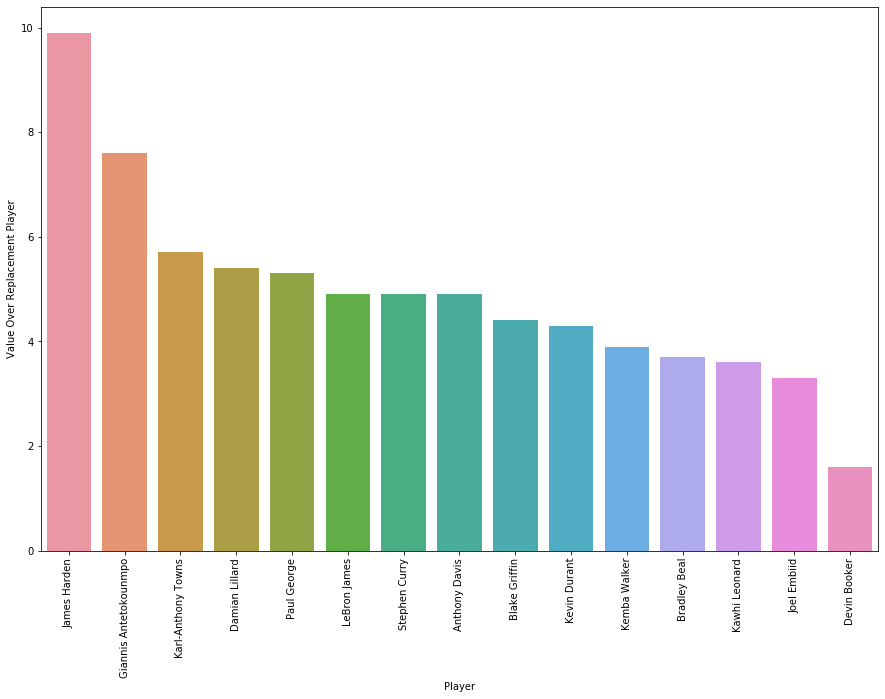

In [78]:
plt.figure(figsize=(15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by value over replacement player in decending order
top_15 = top_15.sort_values(by=['VORP'], ascending=False)
# Create a barplot of the value over replacement player for the top 15 players
ax = sns.barplot(x = 'Player', y = 'VORP', data = top_15)

# Set up axis
ax.set_xlabel('Player')
ax.set_ylabel('Value Over Replacement Player')

# Make x axis lables vertical
plt.xticks(rotation='vertical')

plt.show()

~ Description of graph ~

<center>
<h1 style="font-size:24px"> Win Shares v. Player For Top 15 Scorers</h1>
</center>

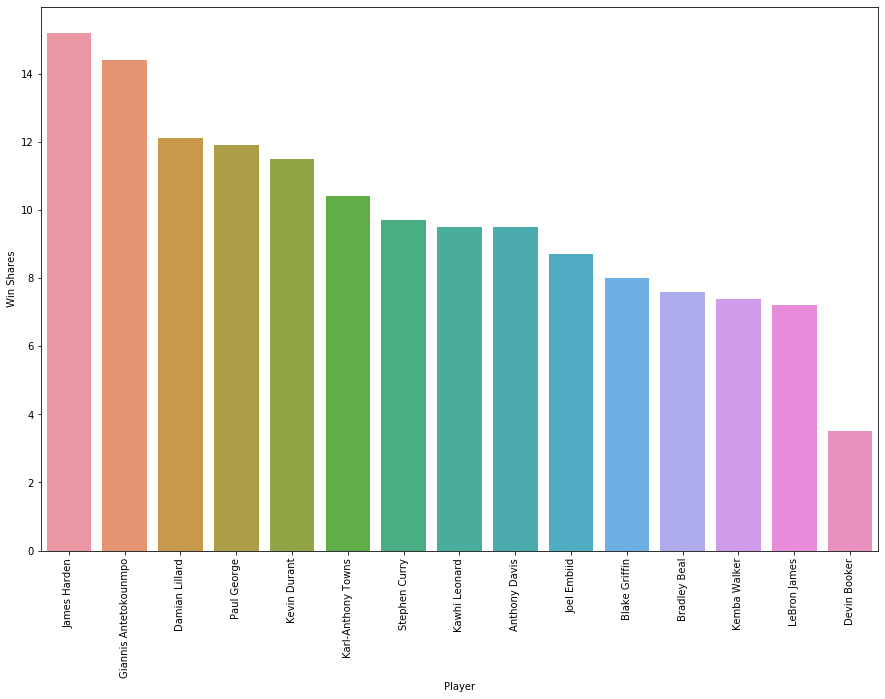

In [77]:
plt.figure(figsize=(15, 10))
# Get top 15 players
top_15 = nba_stats.head(15)
# Order top 15 players by win shares in decending order
top_15 = top_15.sort_values(by=['WS'], ascending=False)
# Create a barplot of the win shares for the top 15 players
ax = sns.barplot(x = 'Player', y = 'WS', data = top_15)

# Set up axis
ax.set_xlabel('Player')
ax.set_ylabel('Win Shares')

# Make x axis lables vertical
plt.xticks(rotation='vertical')

plt.show()

~ Description of graph ~

# **-------- Historical Award Data --------**

## **MVP Award**

- Discuss the MVP award (general background: what it signifies, prior winners, Maurice Podoloff Trophy, etc.)

In [7]:
# We can then go into the MVP Award. I will pull another dataset from Basketball Reference 
nba_mvps = pd.read_csv("nba_mvp_winners.csv")
nba_mvps = nba_mvps.drop(columns=["Lg", "Voting"])

# Cleaning up the name column as usual as well as chenging the season to include only 1 year 
clean_name_column(nba_mvps)  

nba_mvps
# We can then graph whatever we desire for MVPS

,Season,Player,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2018-19,Giannis Antetokounmpo,24,MIL,72,32.8,27.7,12.5,5.9,1.3,1.5,0.578,0.256,0.729,14.4,0.292
1,2017-18,James Harden,28,HOU,72,35.4,30.4,5.4,8.8,1.8,0.7,0.449,0.367,0.858,15.4,0.289
2,2016-17,Russell Westbrook,28,OKC,81,34.6,31.6,10.7,10.4,1.6,0.4,0.425,0.343,0.845,13.1,0.224
3,2015-16,Stephen Curry,27,GSW,79,34.2,30.1,5.4,6.7,2.1,0.2,0.504,0.454,0.908,17.9,0.318
4,2014-15,Stephen Curry,26,GSW,80,32.7,23.8,4.3,7.7,2.0,0.2,0.487,0.443,0.914,15.7,0.288
5,2013-14,Kevin Durant,25,OKC,81,38.5,32.0,7.4,5.5,1.3,0.7,0.503,0.391,0.873,19.2,0.295
6,2012-13,LeBron James,28,MIA,76,37.9,26.8,8.0,7.3,1.7,0.9,0.565,0.406,0.753,19.3,0.322
7,2011-12,LeBron James,27,MIA,62,37.5,27.1,7.9,6.2,1.9,0.8,0.531,0.362,0.771,14.5,0.298
8,2010-11,Derrick Rose,22,CHI,81,37.4,25.0,4.1,7.7,1.0,0.6,0.445,0.332,0.858,13.1,0.208
9,2009-10,LeBron James,25,CLE,76,39.0,29.7,7.3,8.6,1.6,1.0,0.503,0.333,0.767,18.5,0.299


## **Past MVP Winners Seasonal Points Per Game**

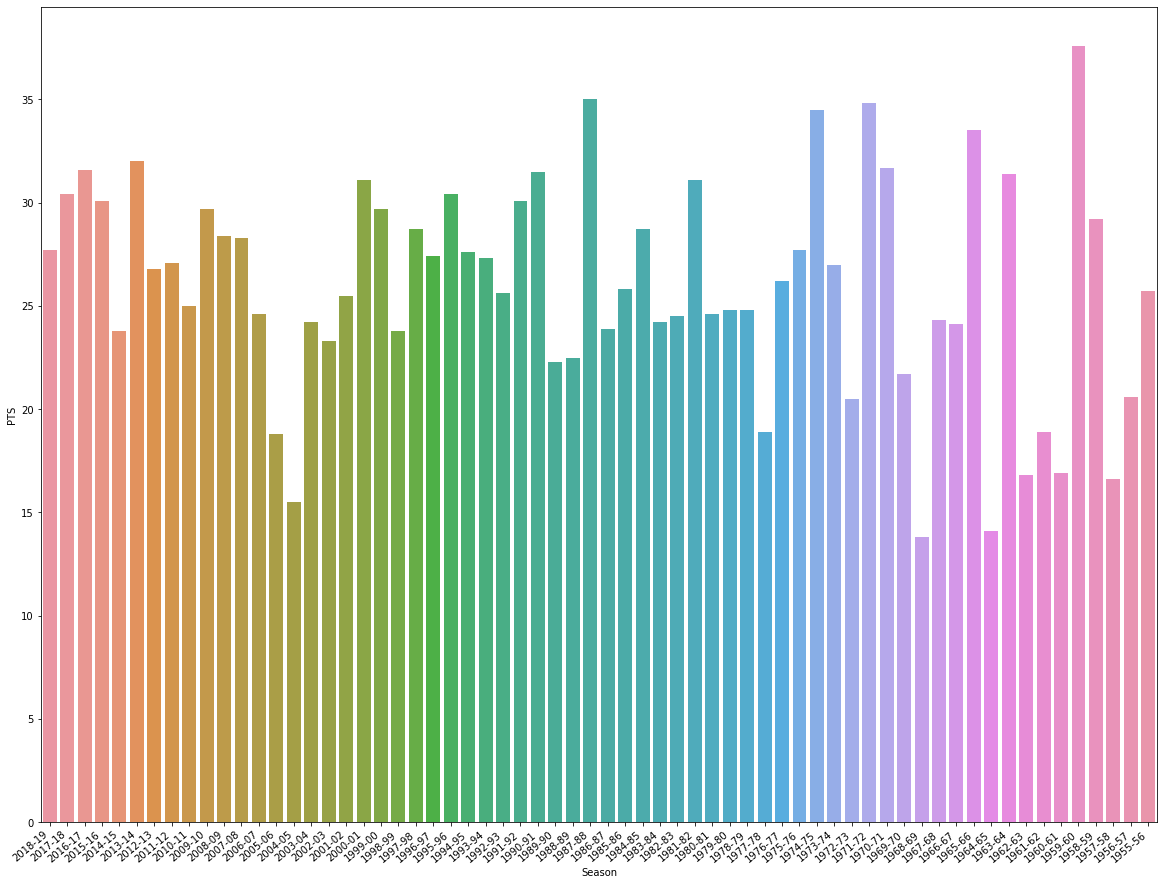

In [8]:
# We can have a scatter plot of the points scored per year 
plt.figure(figsize=(20, 15))
ax = sns.barplot(x = 'Season', y = 'PTS', data = nba_mvps)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

- Talk about this graph
- Stress that points aren't the only thing that matters to be made MVP (bring up specific years that show this)
- Now let's look at win shares (explain win shares)...

## **Past MVP Winners Win Shares**


- Explain what a win share is

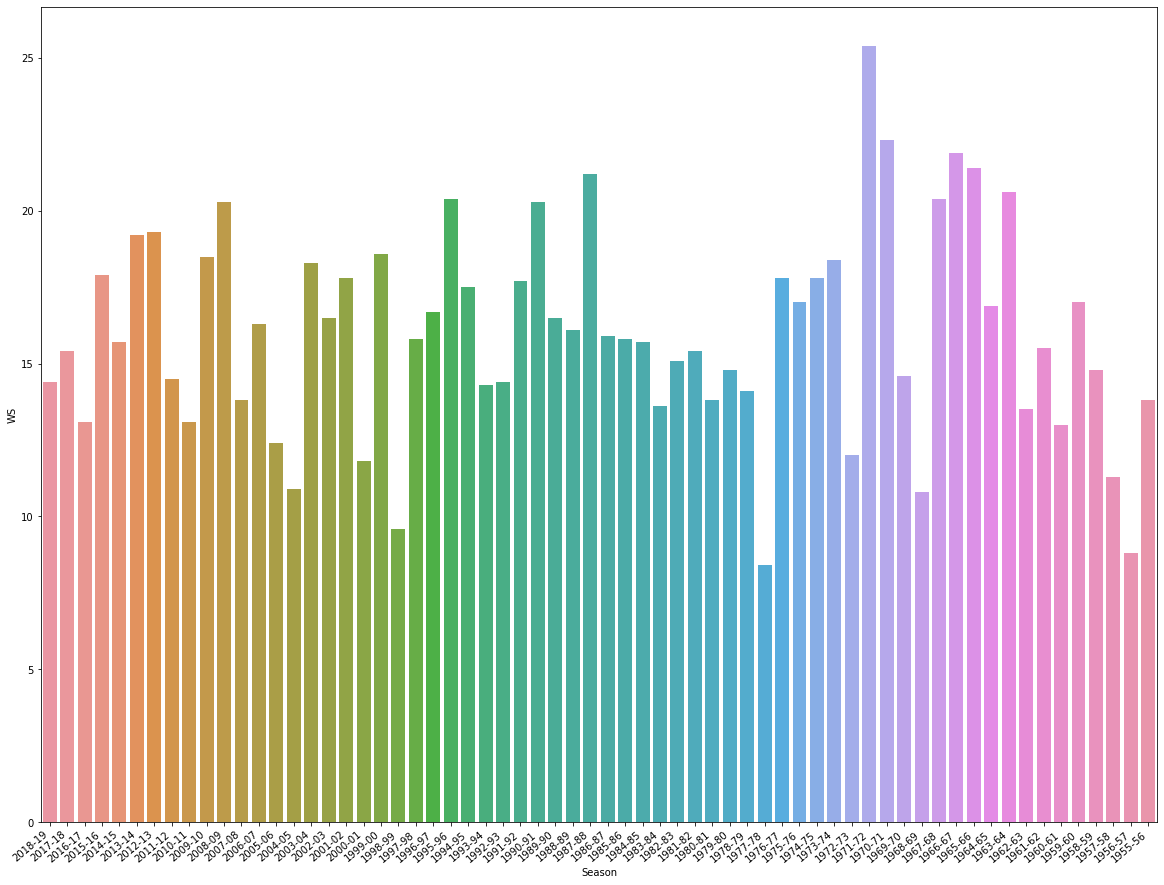

In [9]:
# Insert Win Shares Graphing stuff comparing the win shares between previous MVPs

# We can have a scatter plot of the points scored per year 
plt.figure(figsize=(20, 15))
ax = sns.barplot(x = 'Season', y = 'WS', data = nba_mvps)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [10]:
# Take a sample year (last year 2018-2019 season) and show how the MVP's win shares compare to everyone elses

## **Defensive Player of the Year Award**

- Explain this award and what it means HERE
- Bring up how we ourselves added the positions into this dataset

In [11]:
# Now onto Defensive Player of the Year. Dataset also received from Basketball Reference 
nba_dpoy = pd.read_csv('nba_dopy_winners.csv')
nba_dpoy = nba_dpoy.drop(columns=["Lg","Voting"])

# As before, clean the Player name column 
clean_name_column(nba_dpoy)

nba_dpoy

,Season,Player,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2018-19,Rudy Gobert,26,UTA,81,31.8,15.9,12.9,2.0,0.8,2.3,0.669,NaN,0.636,14.4,0.268
1,2017-18,Rudy Gobert,25,UTA,56,32.4,13.5,10.7,1.4,0.8,2.3,0.622,NaN,0.682,8.1,0.214
2,2016-17,Draymond Green,26,GSW,76,32.5,10.2,7.9,7.0,2.0,1.4,0.418,0.308,0.709,8.2,0.160
3,2015-16,Kawhi Leonard,24,SAS,72,33.1,21.2,6.8,2.6,1.8,1.0,0.506,0.443,0.874,13.7,0.277
4,2014-15,Kawhi Leonard,23,SAS,64,31.8,16.5,7.2,2.5,2.3,0.8,0.479,0.349,0.802,8.6,0.204
5,2013-14,Joakim Noah,28,CHI,80,35.3,12.6,11.3,5.4,1.2,1.5,0.475,0.000,0.737,11.2,0.190
6,2012-13,Marc Gasol,28,MEM,80,35.0,14.1,7.8,4.0,1.0,1.7,0.494,0.071,0.848,11.5,0.197
7,2011-12,Tyson Chandler,29,NYK,62,33.2,11.3,9.9,0.9,0.9,1.4,0.679,0.000,0.689,9.5,0.220
8,2010-11,Dwight Howard,25,ORL,78,37.6,22.9,14.1,1.4,1.4,2.4,0.593,0.000,0.596,14.4,0.235
9,2009-10,Dwight Howard,24,ORL,82,34.7,18.3,13.2,1.8,0.9,2.8,0.612,0.000,0.592,13.2,0.223



## **Rookie of the Year Stats**

- Basically do the same stuff we did for MVP and explain why (how ROY is like the MVP choice but for the current rookie class (aka a subset of all the players))

In [12]:
# We can also look at Rookie of the Year 
nba_roy = pd.read_csv("nba_roy.csv")
nba_roy = nba_roy.drop(columns = ["Lg", "Voting"])

# As before, clean the Player name column 
clean_name_column(nba_roy)

nba_roy

,Season,Player,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2018-19,Luka Dončić,19,DAL,72,32.2,21.2,7.8,6.0,1.1,0.3,0.427,0.327,0.713,4.9,0.101
1,2017-18,Ben Simmons,21,PHI,81,33.7,15.8,8.1,8.2,1.7,0.9,0.545,0.000,0.560,9.2,0.162
2,2016-17,Malcolm Brogdon,24,MIL,75,26.4,10.2,2.8,4.2,1.1,0.2,0.457,0.404,0.865,4.1,0.100
3,2015-16,Karl-Anthony Towns,20,MIN,82,32.0,18.3,10.5,2.0,0.7,1.7,0.542,0.341,0.811,8.3,0.151
4,2014-15,Andrew Wiggins,19,MIN,82,36.2,16.9,4.6,2.1,1.0,0.6,0.437,0.310,0.760,2.1,0.034
5,2013-14,Michael Carter-Williams,22,PHI,70,34.5,16.7,6.2,6.3,1.9,0.6,0.405,0.264,0.703,1.3,0.026
6,2012-13,Damian Lillard,22,POR,82,38.6,19.0,3.1,6.5,0.9,0.2,0.429,0.368,0.844,5.8,0.088
7,2011-12,Kyrie Irving,19,CLE,51,30.5,18.5,3.7,5.4,1.1,0.4,0.469,0.399,0.872,4.1,0.125
8,2010-11,Blake Griffin,21,LAC,82,38.0,22.5,12.1,3.8,0.8,0.5,0.506,0.292,0.642,9.8,0.152
9,2009-10,Tyreke Evans,20,SAC,72,37.2,20.1,5.3,5.8,1.5,0.4,0.458,0.255,0.748,5.4,0.097


## **-------- Current Season Stats (All Players) --------**

In [13]:
# So for the machine larning parts of the project I was thinking we could take the current stats of players and 
# predict who would win all the above awards this year 
curr_stats = pd.read_csv("19_20_nba_stats.csv")
# As before, clean the Player name column 
clean_name_column(curr_stats)


In [14]:
# In order to predict who will win the MVP we will need to predict the voting shares for each of the 
# prospective winners. We will be using historical data from the 2018-2019 MVP voting to train our 
# model on.
prospective_mvps = curr_stats.head(15)
# Importing the historical data 
past_mvp_voting = pd.read_csv('historic_mvp_voting.csv')
clean_name_column(past_mvp_voting)

# Create training and test data

X = past_mvp_voting.iloc[:,10:18]
y = past_mvp_voting.Share
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

neigh = KNeighborsRegressor(n_neighbors = 2)
neigh.fit(X_train, y_train)

regressor = DecisionTreeRegressor(random_state=2)
regressor.fit(X_train, y_train)

prospective_mvps = prospective_mvps[['PTS', "TRB", "AST", "STL", "BLK", "FG%", "FT%", "3P%"]]

prediction1 = neigh.predict(prospective_mvps)
prediction2 = regressor.predict(prospective_mvps)

prediction2


array([0.934, 0.726, 0.726, 0.726, 0.726, 0.934, 0.726, 0.726, 0.726,
       0.726, 0.02 , 0.006, 0.005, 0.006, 0.006])

## **-------- Current Season Stats (Rookies) --------**

In [15]:
# We are going to need an additional dataset for rookie of the year where only rookie stats are present 
rookie_curr_stats = pd.read_csv("nba_rookies_stats.csv")

clean_name_column(rookie_curr_stats)




rookie_curr_stats

,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,FT,FTA,ORB,TRB,AST,STL,BLK,TOV,PF,PTS,FG%,3P%,FT%,MP.1,PTS▼,TRB.1,AST.1
0,1,Ja Morant,Oct 23 '19 MEM @ MIA,20,1,18,518,126,272,19,44,72,93,16,56,116,24,5,60,30,343,0.463,0.432,0.774,28.8,19.1,3.1,6.4
1,2,Eric Paschall,Oct 24 '19 GSW vs. LAC,23,1,24,755,147,296,17,58,87,107,35,125,41,9,9,40,47,398,0.497,0.293,0.813,31.5,16.6,5.2,1.7
2,3,Kendrick Nunn,Oct 23 '19 MIA vs. MEM,24,1,23,689,140,315,47,135,26,33,7,58,78,24,7,49,59,353,0.444,0.348,0.788,30.0,15.3,2.5,3.4
3,4,Tyler Herro,Oct 23 '19 MIA vs. MEM,20,1,22,637,117,261,47,120,39,47,6,89,44,17,3,44,32,320,0.448,0.392,0.830,29.0,14.5,4.0,2.0
4,5,RJ Barrett,Oct 23 '19 NYK @ SAS,19,1,22,707,117,296,22,71,59,111,26,117,72,30,11,54,55,315,0.395,0.310,0.532,32.1,14.3,5.3,3.3
5,6,Rui Hachimura,Oct 23 '19 WAS @ DAL,21,1,22,651,132,273,9,44,40,45,34,127,38,17,3,19,49,313,0.484,0.205,0.889,29.6,14.2,5.8,1.7
6,7,De'Andre Hunter,Oct 24 '19 ATL @ DET,22,1,22,692,94,239,37,105,41,51,11,89,41,14,5,39,58,266,0.393,0.352,0.804,31.5,12.1,4.0,1.9
7,8,PJ Washington,Oct 23 '19 CHO vs. CHI,21,1,25,708,112,228,34,80,44,63,23,127,44,27,21,31,68,302,0.491,0.425,0.698,28.3,12.1,5.1,1.8
8,9,Coby White,Oct 23 '19 CHI @ CHO,19,1,25,632,107,299,51,149,33,42,7,93,61,17,0,37,36,298,0.358,0.342,0.786,25.3,11.9,3.7,2.4
9,10,Brandon Clarke,Oct 23 '19 MEM @ MIA,23,1,18,381,92,146,10,22,19,23,24,106,23,9,17,19,31,213,0.630,0.455,0.826,21.2,11.8,5.9,1.3


This is kind of a general outline for what we will need to do. We have plenty of flexibility with this project, so this not end up being exactly what we do.
    
Getting Started With The Data:
- Data source (explanations of why / where it is from)
- Tidying Data / Data Modification    
- Reading the data (define what each column means for someone who may not know basketball as well)
    
Exploratory Data Analysis/Data Visualization:
- Graphing a bunch of different things and discussing those graphs (1) below
- Finding other important / interesting stats

Machine Learning stuff:
- Hypothesis/Hypotheses
- Linear Regression
- Regression w/ OLS
- Predictions



What we will be visualizing / analyzing:
Past Season:
1. points per game vs. avg number of minutes played (allows you to see who is scoring the most points, which makes them the most valulable ish)
2. same graph as above but only for top 15 players (the goal of this part is to differentiate between "average" players and NBA superstars)
3. FGA (x-axis) v. FG% (y-axis) for all players
4. same graph as above but only for top 15 players (same reason as above--differentiation + showing efficiency).

Historical Data:
- Look into positions for all of these, especially DPOY

MVP:
1. Win shares

ROY:
- This will be similar to MVP, but just a smaller subset (aka the rookie class)

DPOY:


IMPORTANT: For current season make sure to note when the data is from (date/time)

